In [119]:
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

for dirname, dirs,filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

./input/home-credit-default-risk/application_test.csv
./input/home-credit-default-risk/HomeCredit_columns_description.csv
./input/home-credit-default-risk/POS_CASH_balance.csv
./input/home-credit-default-risk/credit_card_balance.csv
./input/home-credit-default-risk/installments_payments.csv
./input/home-credit-default-risk/application_train.csv
./input/home-credit-default-risk/bureau.csv
./input/home-credit-default-risk/previous_application.csv
./input/home-credit-default-risk/bureau_balance.csv
./input/home-credit-default-risk/sample_submission.csv


In [120]:
Train = pd.read_csv('./input/home-credit-default-risk/application_train.csv')
print('-' * 80)
print('application_train.csv has been imported.')

Test = pd.read_csv('./input/home-credit-default-risk/application_test.csv')
print('-' * 80)
print('application_test.csv has been imported.')

prevApp = pd.read_csv('./input/home-credit-default-risk/previous_application.csv')
print('-' * 80)
print('previous_application.csv has been imported.')

bureau_row = pd.read_csv('./input/home-credit-default-risk/bureau.csv')
print('-' * 80)
print('bureau.csv has been imported.')

bb_row = pd.read_csv('./input/home-credit-default-risk/bureau_balance.csv')
print('-' * 80)
print('bureau_balance.csv has been imported.')

--------------------------------------------------------------------------------
application_train.csv has been imported.
--------------------------------------------------------------------------------
application_test.csv has been imported.
--------------------------------------------------------------------------------
previous_application.csv has been imported.
--------------------------------------------------------------------------------
bureau.csv has been imported.
--------------------------------------------------------------------------------
bureau_balance.csv has been imported.


## Data Processing & Feature Engineering
1. Check for outliers and clean the missing value
2. reorganize and downscale individual category data columns
3. change the values of two-dimensional category data columns to 0 and 1
4. introduce new features for important features

In [121]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Dataset#1: Application_{train|test}

In [122]:
def application():

    df = pd.concat([Train,Test],ignore_index=True)
    
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000] # remove a outlier 117M
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # set null value
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value


    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques=pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df)
    
    #Document aggregate Number as a new feature
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    
    #External Source mutual Prob
    df['MUTUAL_PROB_EXT']=df['EXT_SOURCE_1']*df['EXT_SOURCE_2']*df['EXT_SOURCE_3']
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit ratios
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['INCOME_TO_CHILD_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_CHILDREN']
    
    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    
    # AMT_INCOME_TOTAL : income
    # CNT_FAM_MEMBERS  : the number of family members
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH : Client's age in days at the time of application
    # DAYS_EMPLOYED : How many days before the application the person started current employment
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    
    print('"Application_Train_Test" final shape:', df.shape)
    return df
    

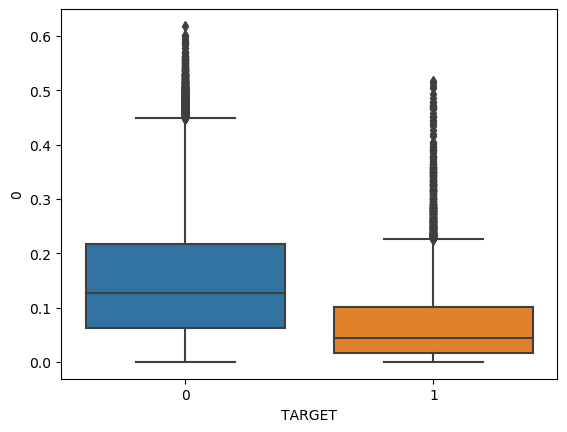

In [144]:
y=Train['TARGET']
x=Train['EXT_SOURCE_1']*Train['EXT_SOURCE_2']*Train['EXT_SOURCE_3']
data = pd.concat([x, y], axis=1)
data.columns
sns.boxplot(data=data,x=data['TARGET'],y=data[0])

In [123]:
def bureau_bb():
    bureau = bureau_row.copy()
    bb = bb_row.copy()
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

    # CREDIT_DAY_OVERDUE :
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)

    bb, bb_cat = one_hot_encoder(bb)
    bureau, bureau_cat = one_hot_encoder(bureau)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    #Status of Credit Bureau loan during the month
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'min'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'SK_ID_BUREAU': ['count'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_IS_DPD': ['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120': ['mean', 'sum']
        }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)
    return bureau_agg

In [145]:
def previous_application():
    prev = prevApp.copy()
    
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # from off
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'DAYS_TERMINATION': ['max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'sum'],
        'DOWN_PAYMENT_TO_CREDIT': ['mean'],
        'PREV_GOODS_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO': ['mean', 'max'],
        'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'sum'],
        'SIMPLE_INTERESTS': ['mean', 'max']
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    print('"Previous Applications" final shape:', prev_agg.shape)
    return prev_agg

In [146]:
Dataset = application()
Dataset = Dataset.merge(bureau_bb(),how='left',on='SK_ID_CURR')
print('--=> Dataset after merge with bureau:', Dataset.shape)
Dataset = Dataset.merge(previous_application(), how='left', on='SK_ID_CURR')
print('--=> Dataset after merge with previous application:', Dataset.shape)

"Application_Train_Test" final shape: (356250, 273)
"Bureau/Bureau Balance" final shape: (305811, 200)
--=> df after merge with bureau: (356250, 473)
"Previous Applications" final shape: (338857, 321)
--=> df after merge with previous application: (356250, 794)
